<a href="https://colab.research.google.com/github/Kravty/Applied-ML/blob/main/MLflow_PyTorch_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intro

In this notebook, I'm going to present experiment tracking using [MLflow Tracking](https://mlflow.org/docs/latest/tracking.html) for model training in [PyTorch](https://pytorch.org/) on the CIFAR-100 dataset. The usage of MLflow Tracking in colab is not as simple as the local one. To view MLflow dashboard I will tunnel its localhost to the public URL using [ngrok](https://ngrok.com).

In [ ]:
# install MLflow
!pip install mlflow --quiet
# instal pyngrok to tunnel localhost with MLflow dashboard to public URL
!pip install pyngrok --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Imports
# line to plot matplotlib figures in colab
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import copy
import pickle  # to decode saved dataset
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
import mlflow
# from mlflow.tracking import MlflowClient
from pyngrok import ngrok
# import dagshub
import os
from getpass import getpass

In [ ]:
# let's make sure PyTorch 2.0 is used
print(f'Version of PyTorch used: {torch.__version__}')

Version of PyTorch used: 2.0.1+cu118


In [ ]:
# set up device
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
if device == torch.device("cuda"):
    cudnn.benchmark = True  # speed up calculation for fixed size input

## Loading dataset

[CIFAR-10 and CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) are well-known datasets for image classification developed at [University of Toronto](https://web.cs.toronto.edu/) for the purpose of [this paper](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf). I will use the CIFAR-100 dataset in this notebook since CIFAR-10 is used in most tutorials. CIFAR-100 consists of 60 000 32x32 color images. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. There are 600 images per class. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs). There are 500 training images and 100 testing images per class.

In [ ]:
# download CIFAR-100 dataset
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
# unpack zip file
!tar -xf cifar-100-python.tar.gz
# remove redundant zip file
!rm cifar-100-python.tar.gz

--2023-06-07 12:44:51--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  5.30MB/s    in 42s     

2023-06-07 12:45:34 (3.87 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]



In [ ]:
# let's define dict with superclasses and it's classes.
cifar_100_label_dict = {
    'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
    'fish': ['aquarium fish', 'flatfish', 'ray', 'shark', 'trout'],
    'flowers': ['orchids', 'poppies', 'roses', 'sunflowers', 'tulips'],
    'food containers': ['bottles', 'bowls', 'cans', 'cups', 'plates'],
    'fruit and vegetables': ['apples', 'mushrooms', 'oranges', 'pears',
                             'sweet peppers'],
    'household electrical devices': ['clock', 'keyboard (computer)', 'lamp',
                                     'telephone', 'television'],
    'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
    'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
    'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
    'large man-made outdoor things': ['bridge', 'castle', 'house', 'road',
                                      'skyscraper'],
    'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain',
                                     'sea'],
    'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee',
                                       'elephant', 'kangaroo'],
    'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
    'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
    'people': ['baby', 'boy', 'girl', 'man', 'woman'],
    'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
    'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
    'trees': ['maple', 'oak', 'palm', 'pine', 'willow'],
    'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup truck', 'train'],
    'vehicles 2': ['lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']
}

In [ ]:
# let's present this superclasses and its classes in more readable way
cifar_classes_df = pd.DataFrame.from_dict(cifar_100_label_dict, orient='index')
cifar_classes_df.index.name = 'Superclass'
cifar_classes_df.columns = ['Class ' + str(i) for i in range(len(cifar_classes_df.columns))]
cifar_classes_df

,Class 0,Class 1,Class 2,Class 3,Class 4
Superclass,,,,,
aquatic mammals,beaver,dolphin,otter,seal,whale
fish,aquarium fish,flatfish,ray,shark,trout
flowers,orchids,poppies,roses,sunflowers,tulips
food containers,bottles,bowls,cans,cups,plates
fruit and vegetables,apples,mushrooms,oranges,pears,sweet peppers
household electrical devices,clock,keyboard (computer),lamp,telephone,television
household furniture,bed,chair,couch,table,wardrobe
insects,bee,beetle,butterfly,caterpillar,cockroach
large carnivores,bear,leopard,lion,tiger,wolf


When you take a look a the table, you may be surprised by some class assignments to superclasses,
but citing Alex Krizhevsky, the developer of this dataset and AlexNet: <br>
'*Yes, I know mushrooms aren't really fruit or vegetables and bears
aren't really carnivores.*'

Well, who knows, maybe those little bastards only want us to think they like honey...
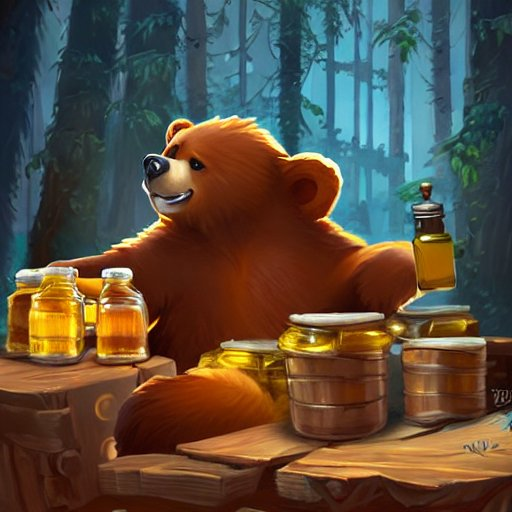
<br>
*Image generated by [Stable Diffusion](https://stablediffusionweb.com/#demo)* (prompt: bear selling honey, artstation)

In [ ]:
# function to  decode downloaded dataset files
def unpickle(filename: str)-> dict:
    with open(filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
train = unpickle('cifar-100-python/train')
train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [ ]:
# let's check shape of the data
train[b'data'].shape

(50000, 3072)

Thus we have 50 000 (500 samples $\cdot$ 100 classes) samples in the train set as expected. <br> Remaining dimension 3072 is a flattened image (3 RGB channels$\cdot$ 32px width $\cdot$ 32px height)

In [ ]:
# let's reshape flattened images
# -1 at first position tells PyTorch to find this dim based on other dims
train[b'data'] = train[b'data'].reshape((-1, 3, 32, 32))
# change order of channels to supported by matplotlib
train[b'data'] = train[b'data'].transpose(0, 2, 3, 1)
train[b'data'].shape

(50000, 32, 32, 3)

In [ ]:
# numbers of labels colacate to all classes sorted alphabetically
# let's convert previous dataframe to such labels
labels_names = cifar_classes_df.values.tolist()  # convert values to nested list
# unpack nested list
labels_names = [val for sublist in labels_names for val in sublist]
labels_names.sort()  # sort list of labels alphabetically
# now let's do the same for superclasses
superclass_names = cifar_classes_df.index.tolist()
superclass_names.sort()  # sort list of labels alphabetically

In [ ]:
# let's create function to plot exemplary images in grid
def plot_grid(images: np.array, labels: np.array, len_rows: int=3,
              len_columns: int=3) -> None:
  '''
  Function to plot images in grid of shape specified by user

  :param images: np.array of flattened images
  :param labels: np.array of (fine) labels
  :param len_rows: rows number in grid
  :param len_columns: columns number in grid
  :return: None - plots grid with images
  '''

  # define grid and figure size
  fig, axs = plt.subplots(len_rows, len_columns, figsize=(2 * len_columns,
                                                          2 * len_rows))
  for row in range(len_rows):
    for col in range(len_columns):
        image_idx = np.random.randint(images.shape[0])  # choose random index
        image = images[image_idx]
        axs[row, col].imshow(image)
        # remove x- and y-axis ticks
        axs[row, col].get_xaxis().set_visible(False)
        axs[row, col].get_yaxis().set_visible(False)
        # add label name above each image
        axs[row, col].set_title(labels_names[labels[image_idx]])
  return

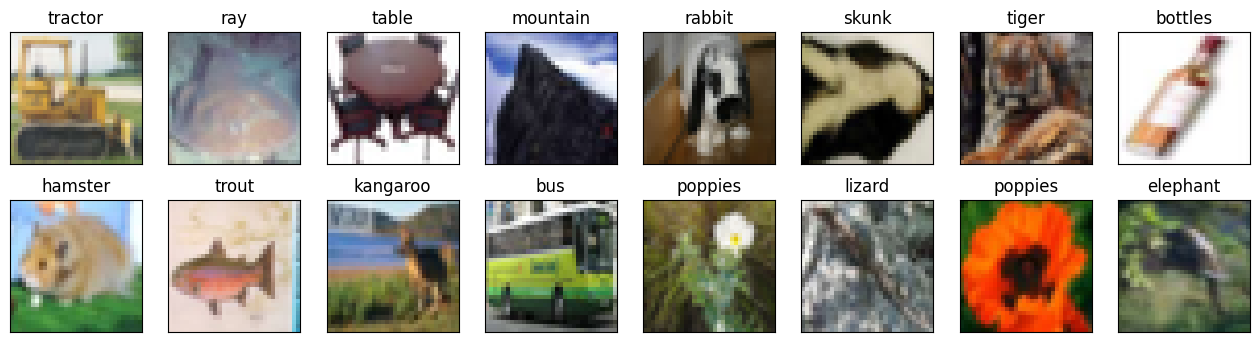

In [ ]:
# let's plot 2x8 grid of exemplary images
plot_grid(images=train[b'data'], labels=train[b'fine_labels'], len_rows=2,
          len_columns=8)

In [ ]:
# let's unpack test dataset
test = unpickle('cifar-100-python/train')
test.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [ ]:
# let's reshape test images
test[b'data'] = test[b'data'].reshape((-1, 3, 32, 32))
# change order of channels to supported by matplotlib
test[b'data'] = test[b'data'].transpose(0, 2, 3, 1)
test[b'data'].shape

(50000, 32, 32, 3)

In [ ]:
# let's define train, validation/dev and test sets
seed = 42  # set for reproducity
X_train, y_train = train[b'data'], np.array(train[b'fine_labels'])
# since only test set is defined we have to split those data into dev and test set
test[b'fine_labels'] = np.array(test[b'fine_labels'])  # convert list into array
# data is split in 50:50 ratio in stratified fashion (keeps class balance)
X_dev, X_test, y_dev, y_test = train_test_split(test[b'data'],
                                                test[b'fine_labels'],
                                                test_size=0.5,
                                                random_state=seed,
                                                stratify=test[b'fine_labels'])

In [ ]:
print(f'Train set has {X_train.shape[0]} examples.\nHistogram for train set:')
print(f'Dev set has {X_dev.shape[0]} examples')
print(f'Test set has {X_test.shape[0]} examples')

Train set has 50000 examples.
Histogram for train set:
Dev set has 25000 examples
Test set has 25000 examples


In [ ]:
# let's define function to plot histogram
plot_histogram = lambda data: sns.histplot(data=data, bins=len(labels_names))

Dev set histogram:


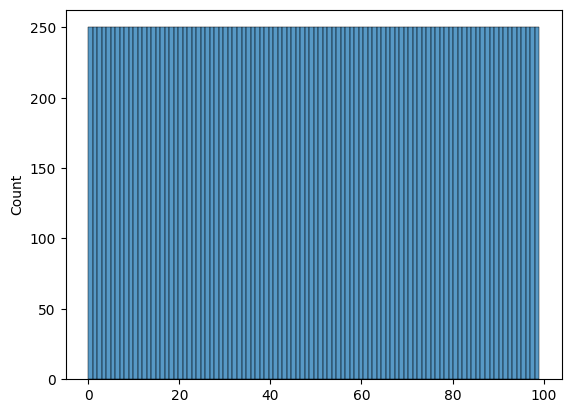

In [ ]:
# check if dev and test sets have balanced classes
print('Dev set histogram:')
plot_histogram(y_dev);

Test set histogram:


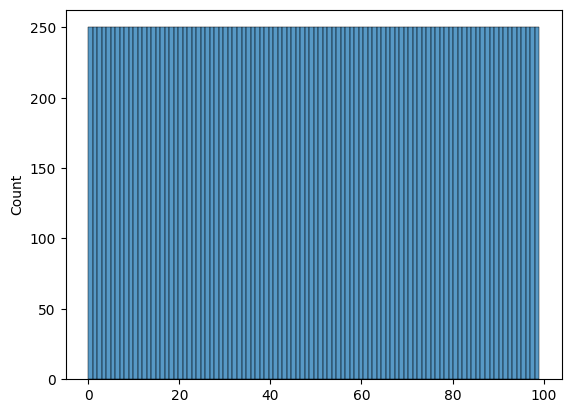

In [ ]:
print('Test set histogram:')
plot_histogram(y_test);

Both dev and test sets are perfectly balanced, thus stratified split worked. Now, let's create data tranform and data loaders.

In [ ]:
data_transform = dict(
    train=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((36, 36)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop((X_train.shape[1], X_train.shape[1])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    test=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((X_test.shape[1], X_test.shape[1])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

In [ ]:
class CifarDataset(Dataset):
    def __init__(self, dataset, labels, transform=None):
        self.dataset = dataset
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        image = self.dataset[index]
        if self.transform is not None:
            image = self.transform(image)
        label = self.labels[index]

        return image, label

    def __len__(self):
        return len(self.dataset)

In [ ]:
batch_size = 128
train_dataset = CifarDataset(X_test, y_test, transform=data_transform["train"])
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False,
                          pin_memory=True)
dev_dataset = CifarDataset(X_test, y_test, transform=data_transform["test"])
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False,
                        drop_last=False,
                        pin_memory=True)
test_dataset = CifarDataset(X_test, y_test, transform=data_transform["test"])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         drop_last=False,
                         pin_memory=True)

## Load model

Due to the colab limitation, I'm not going to use one of the biggest models but rather a small and efficient one. Since I'm using PyTorch, I will use [pre-trained model from torchvision](https://pytorch.org/vision/stable/models.html). In this notebook, I will use the [MobileNetV3](https://arxiv.org/pdf/1905.02244v5.pdf) model, which was designed to be accurate, while computationally efficient to run on e.g. edge devices.

In [ ]:
pretrained_model = torchvision.models.mobilenet_v3_small(weights='MobileNet_V3_Small_Weights.IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 47.0MB/s]


Using ImageNet weights for CIFAR-100 classification can be considered cheating since few classes may overlap. However, the idea of this notebook is to present experiment tracking, and training the model from scratch for each experiment on colab resources is infeasible.

In [ ]:
# Let's print layers of the model
pretrained_model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

Pre-trained model has 1000 output classes, while CIFAR-100 has 100, thus we have to replace last Linear layer

In [ ]:
# to replace last layer number of in_features from previous layer is needed
num_in_features = pretrained_model.classifier[-1].in_features
# replace last layer with new one
pretrained_model.classifier[-1] = torch.nn.Linear(num_in_features, len(labels_names))
# let's use Xavier weights initialization for the new layer
torch.manual_seed(seed)  # random state for reproducibility
torch.nn.init.xavier_uniform_(pretrained_model.classifier[-1].weight)
# move model to device
pretrained_model = pretrained_model.to(device)

## Model training

Let's define training and testing functions. Since the dataset is balanced, we can use standard accuracy as the optimizing metric.

In [ ]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        # use mixed precision to speed up training
        with torch.autocast(device_type='cuda'):
            outputs = model(X)
            loss = criterion(outputs, y)
            losses.append(loss.item())
            optimizer.zero_grad()  # Zero the gradients accumulated by PyTorch
            # Backward and optimize
            loss.backward()
            optimizer.step()

    # Taking mean value of previous losses as loss per epoch
    losses = np.mean(losses)

    return losses

In [ ]:
def test(model, criterion, test_loader):
    model.eval()
    losses = []
    preds, gt = [], []  # will be used for accuracy and confusion matrix

    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            losses.append(loss.item())
            # save predictions and ground truths for evaluation
            softmax_outputs = torch.nn.functional.softmax(input=outputs, dim=1)
            softmax_vals, indices = softmax_outputs.max(1)
            y = y.detach().cpu().numpy()
            pred = indices.detach().cpu().numpy()
            if len(preds) == 0:
                preds.append(pred)
                gt.append(y)
            else:
                preds[0] = np.append(preds[0], pred, axis=0)
                gt[0] = np.append(gt[0], y, axis=0)

    preds = np.concatenate(np.array(preds), axis=0)
    gt = np.concatenate(np.array(gt), axis=0)
    # Taking mean value of previous losses as loss per epoch
    losses = np.mean(losses)

    return losses, preds, gt

In [ ]:
def fit_model(pretrained_model, learning_rate, run_name):
  # copy pre-trained model to start each run from same starting point
  model = copy.deepcopy(pretrained_model)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                              step_size=int(epochs / 4),
                                              gamma=0.5)
  best_optim_metric = 0
  best_model_path = 'best_model.pth'
  epoch_iterator = tqdm(range(epochs),
                      desc="Epoch X: train_loss=X, dev_loss=X, dev_acc=X",
                      bar_format="{l_bar}{r_bar}",
                      dynamic_ncols=True,
                      disable=False)
  with mlflow.start_run(run_name=run_name) as run:
        # Retrieve run id
        RUN_ID = run.info.run_id
        # Track parameters
        mlflow.log_param("learning_rate", learning_rate)
        for epoch in epoch_iterator:
          train_loss = train(model, criterion, optimizer, train_loader)
          dev_loss, dev_preds, dev_gt = test(model, criterion, dev_loader)
          dev_accuracy = (dev_preds == dev_gt).sum().item() / len(dev_gt)
          # Track metrics
          mlflow.log_metric("train_loss", train_loss)
          mlflow.log_metric("dev_loss", dev_loss)
          mlflow.log_metric("dev_accuracy", dev_accuracy)

          epoch_iterator.set_description(
              f"Epoch {epoch + 1}: train_loss={train_loss:.5f}, dev_loss={dev_loss:.5f}, dev_acc={dev_accuracy:.3f}")

          # save checkpoint if optimizing metric improved
          if dev_accuracy > best_optim_metric:
              model_state_dict = model.state_dict()
              torch.save(
                  dict(
                  epoch=epoch+1,
                  state_dict=model_state_dict,
                  optimizer_state_dict=optimizer.state_dict(),
                  ),
                  best_model_path)
              best_optim_metric = dev_accuracy  # update best_optim_metric

        # run best model on test set
        checkpoint = torch.load(best_model_path, map_location=device)
        model.load_state_dict(checkpoint["state_dict"])
        test_loss, test_preds, test_gt = test(model, criterion, test_loader)
        test_accuracy = (test_preds == test_gt).sum().item() / len(test_gt)
        mlflow.log_metric("test_accuracy", test_accuracy)
        # Track model
        mlflow.pytorch.log_model(model, "classifier")

In [ ]:
epochs = 50
criterion = torch.nn.CrossEntropyLoss().to(device)
learning_rates = [5e-3, 1e-3, 5e-4]
for idx, learning_rate in enumerate(learning_rates):
    # Start MLflow
    RUN_NAME = f"run_{idx}"
    fit_model(pretrained_model, learning_rate=learning_rate, run_name=RUN_NAME)

Epoch 50: train_loss=3.16478, dev_loss=3.26925, dev_acc=0.213: 100%|| 50/50 [27:00<00:00, 32.40s/it]
2023/06/07 13:12:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/06/07 13:12:58 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.wa

In [ ]:
# in colab we have to use such command instead of mlflow ui to run next cells
get_ipython().system_raw("mlflow ui --port 5000 &")

In [ ]:
# tunnel MLflow dashboard to public URL
# Terminate open tunnels if exist
ngrok.kill()
from getpass import getpass
NGROK_AUTH_TOKEN = getpass('Enter the ngrok authtoken: ')
ngrok.set_auth_token(NGROK_AUTH_TOKEN)
# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI public URL:", ngrok_tunnel.public_url)

Enter the ngrok authtoken: ··········


MLflow Tracking UI public URL: https://e348-34-143-230-193.ngrok-free.app


Let's take a look at the dashboard of mlflow

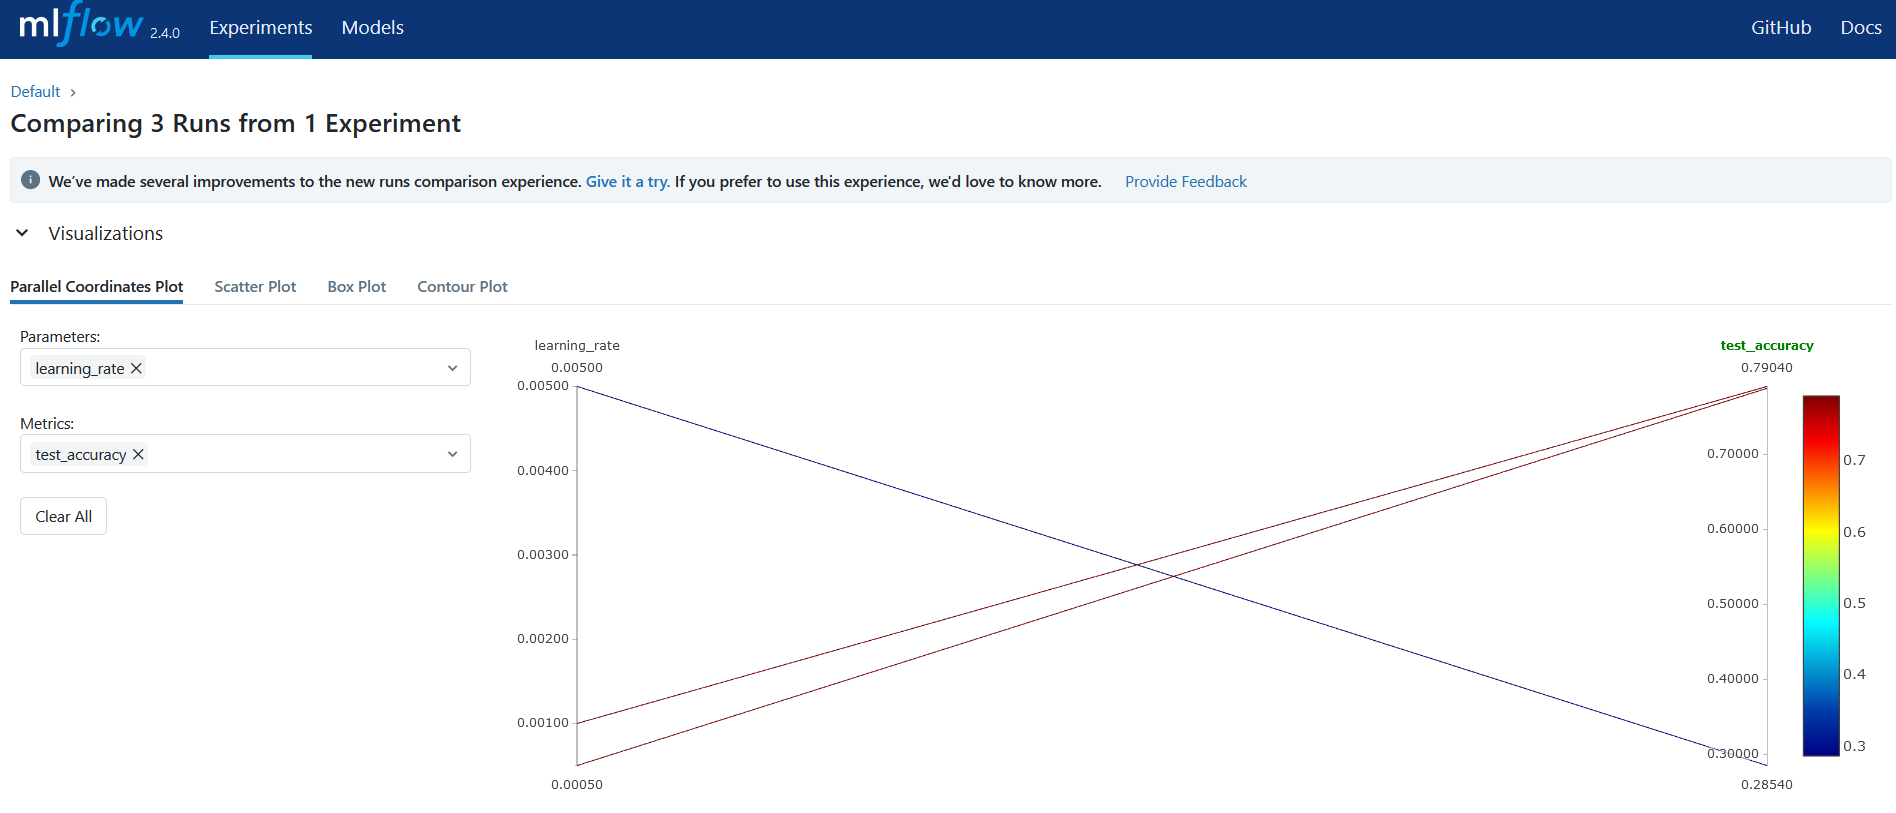

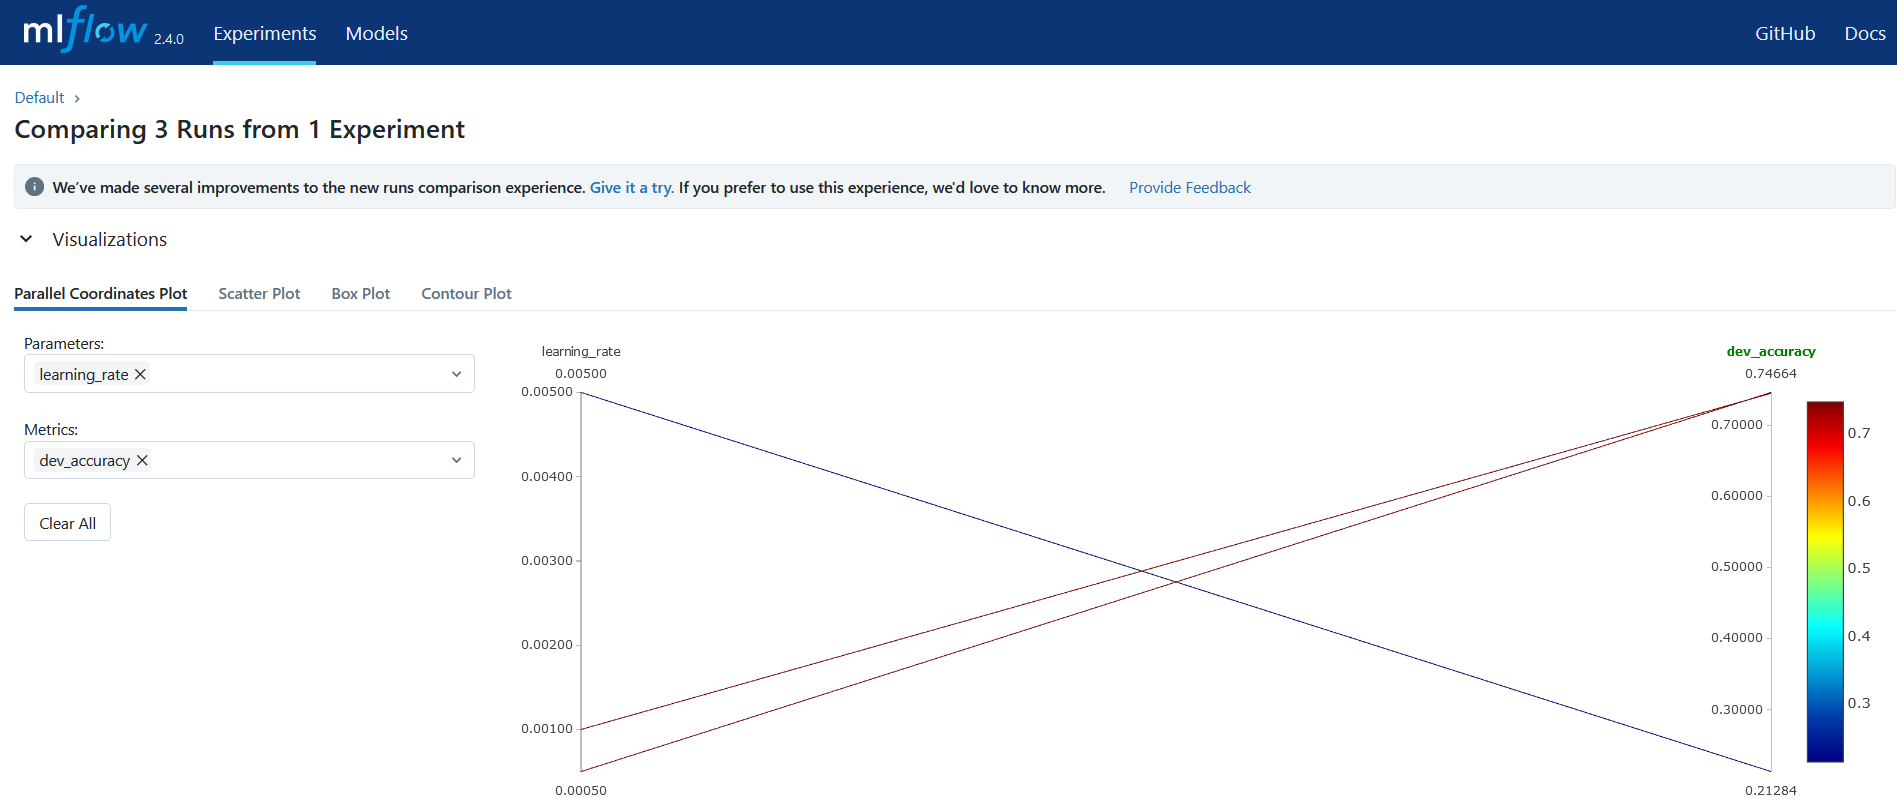

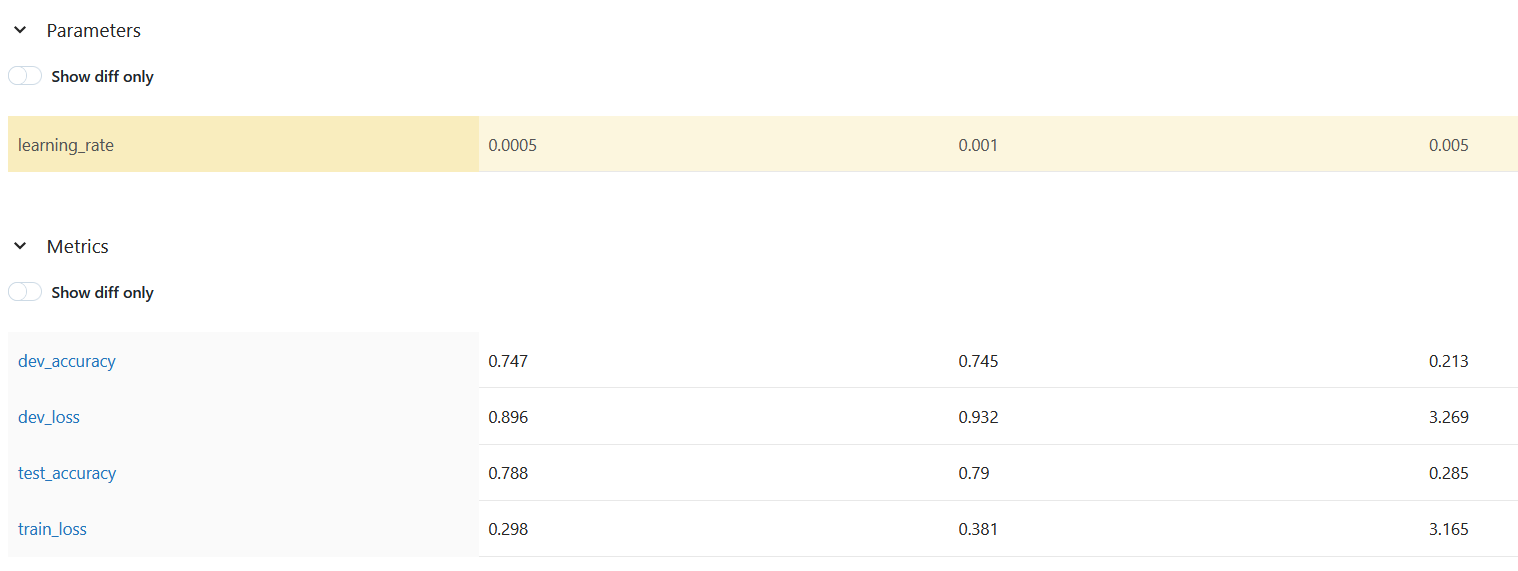

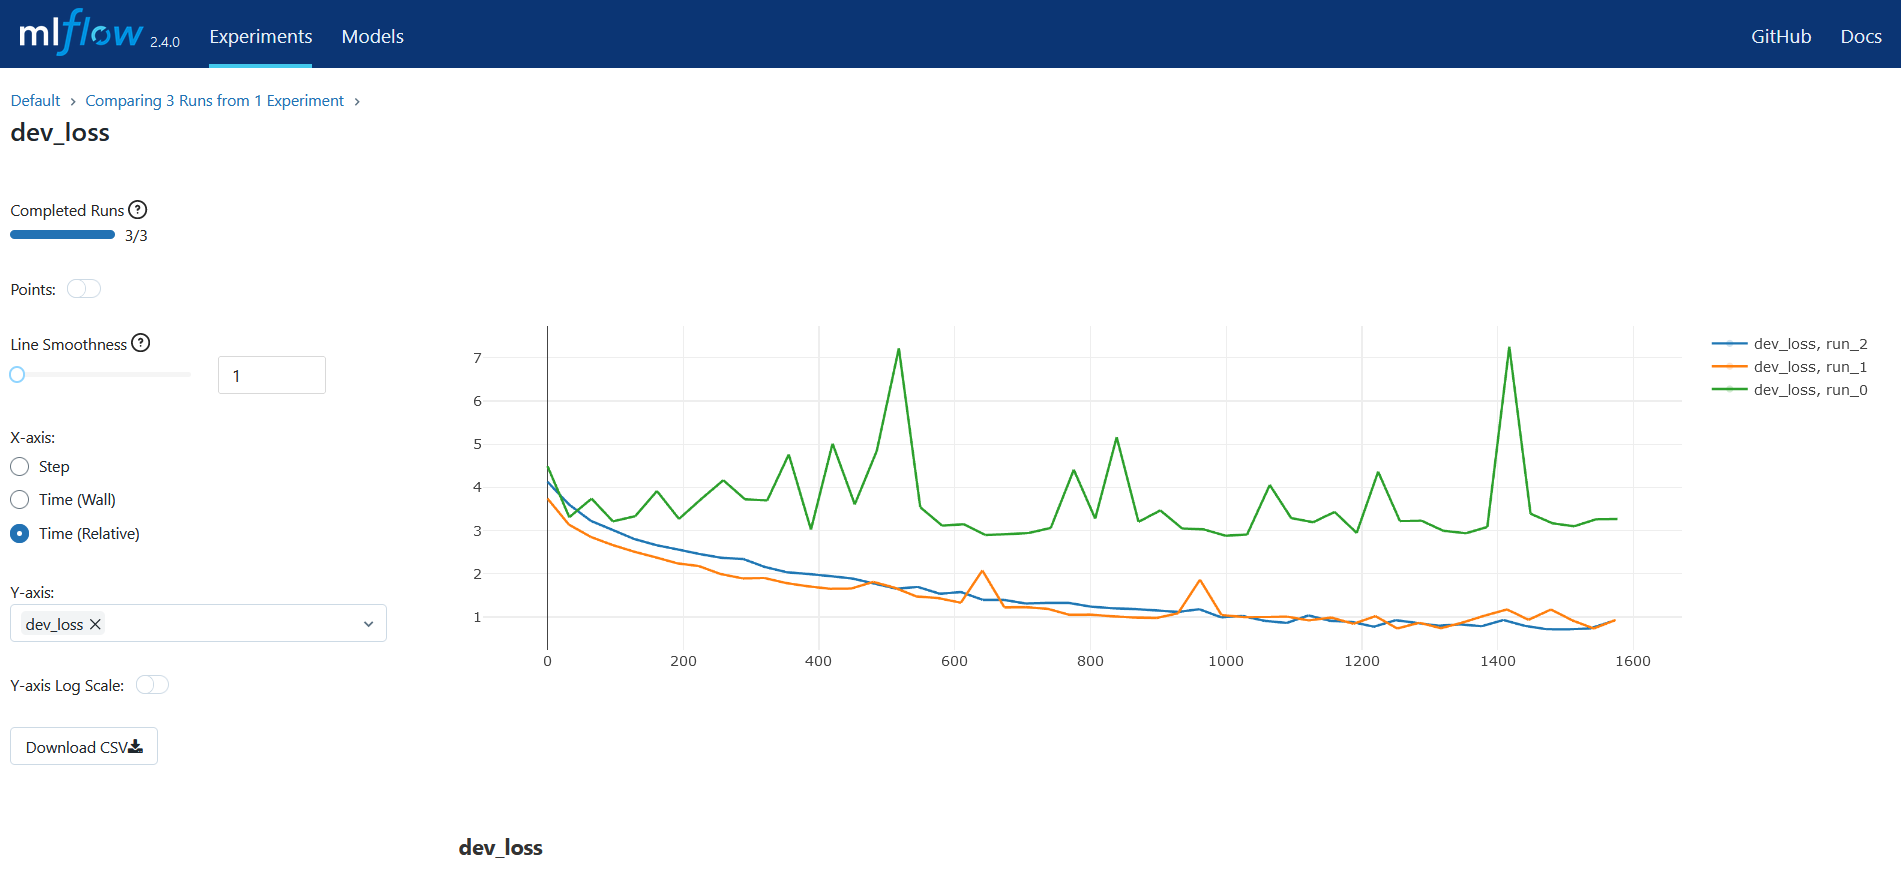

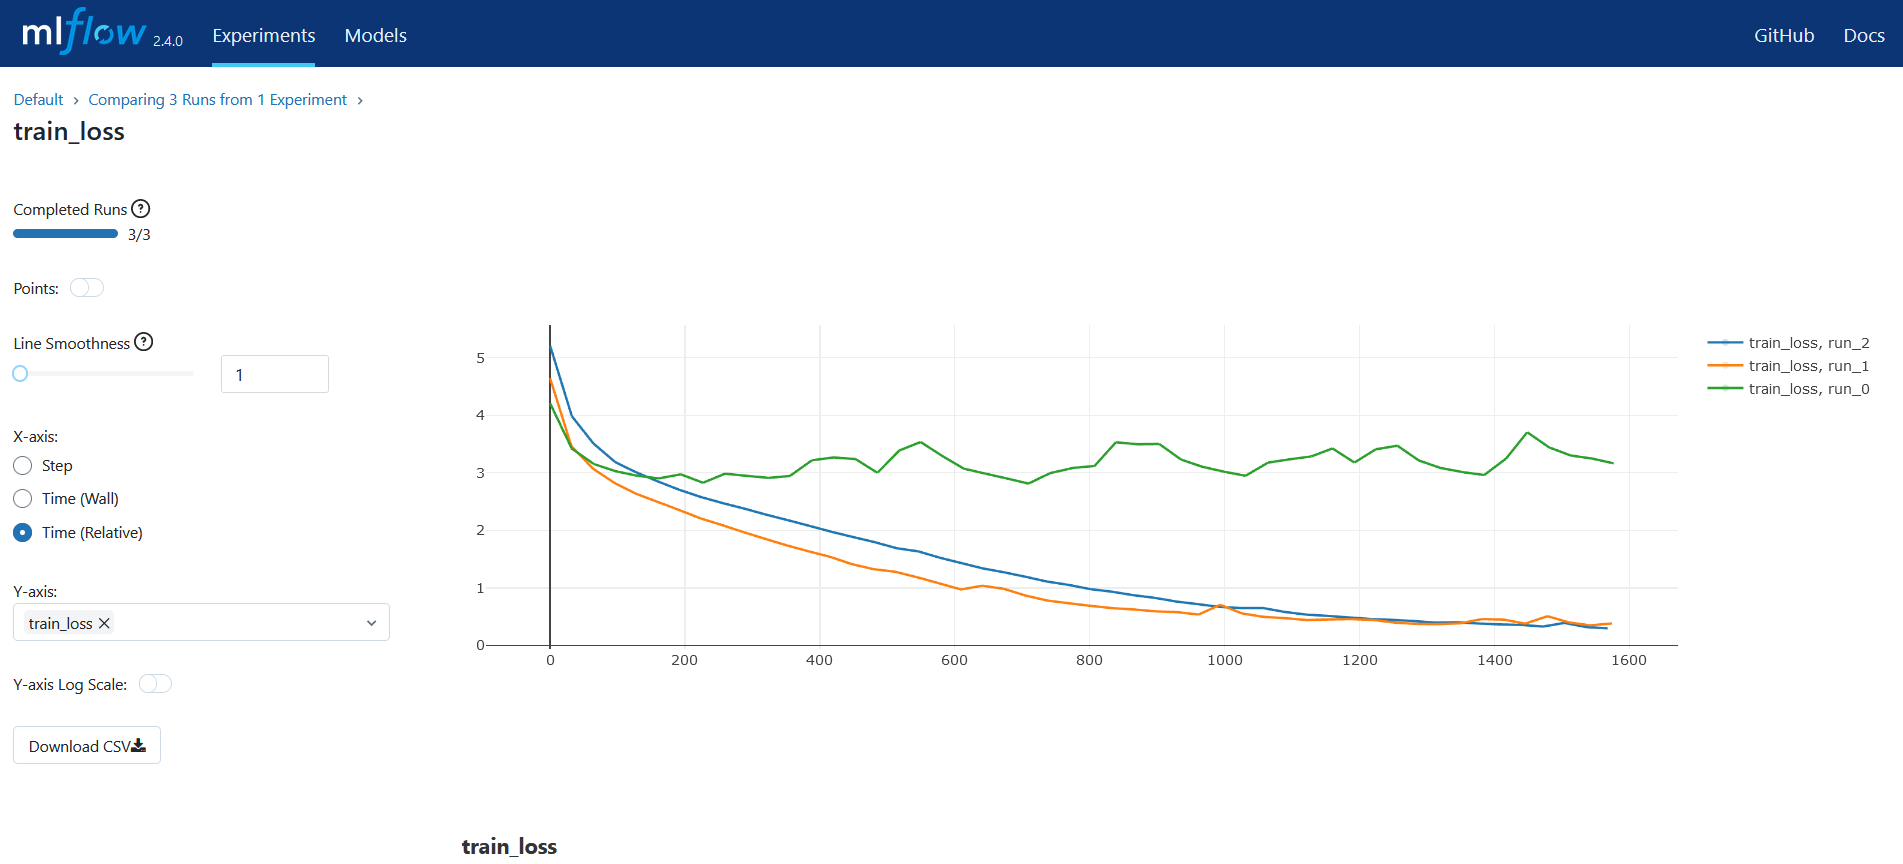

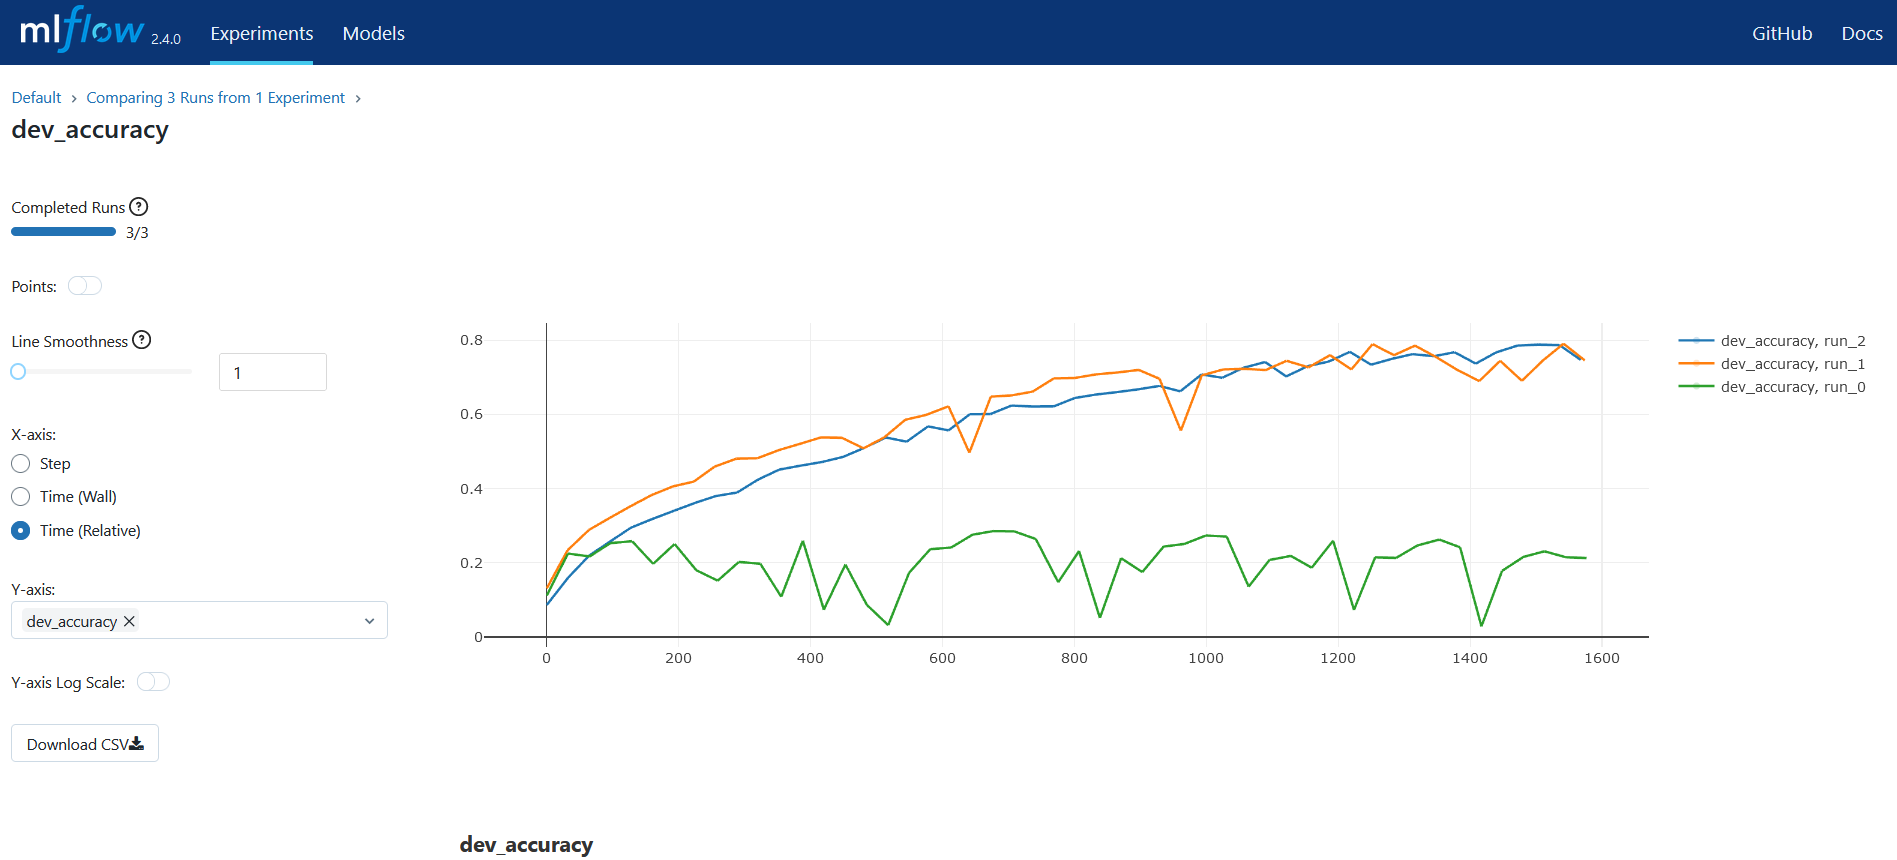